In [1]:
#!/usr/bin/env python3
"""
Condition-based Functional ROI Creation
Uses individual condition activations (face>all, word>all) to define ROI
Then extracts contrast (face-word) from these voxels
"""

import numpy as np
import nibabel as nib
from pathlib import Path
from scipy import ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, surface

BASE_DIR = Path('/user_data/csimmon2/long_pt')

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-007': {'code': 'OT', 'sessions': ['01', '03', '04'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

def create_condition_based_roi(subject_id, roi_type='face_word', threshold=2.3):
    """
    Create ROI from condition activations (not contrasts)
    roi_type: 'face_word' or 'object_house'
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()}")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and copes based on roi_type
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num = 6  # face>all
        cope2_num = 9  # word>all
        cope_names = ['face', 'word']
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num = 8  # object>all
        cope2_num = 7  # house>all
        cope_names = ['object', 'house']
    
    # Load anatomical constraint
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load condition activations
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # Create functional mask: responsive to EITHER condition
    functional_mask = ((cope1_data > threshold) | (cope2_data > threshold)) & anat_mask
    
    # Get largest cluster only
    labeled, n_clusters = ndimage.label(functional_mask)
    
    if n_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
        largest_idx = np.argmax(cluster_sizes) + 1
        functional_mask = (labeled == largest_idx)
        
        n_voxels = cluster_sizes[largest_idx - 1]
        print(f"Found {n_clusters} clusters, keeping largest: {n_voxels} voxels")
    else:
        n_voxels = 0
        print("No clusters found!")
    
    # Get center of mass
    if n_voxels > 0:
        coords = np.where(functional_mask)
        center_vox = [np.mean(c) for c in coords]
        center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
        print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save functional ROI
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_condition_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'cope1_img': cope1_img,
        'cope2_img': cope2_img,
        'functional_mask': functional_mask,
        'anat_roi': anat_roi
    }

# Create ROIs for all subjects
roi_results = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results[subject_id] = {}
    roi_results[subject_id]['face_word'] = create_condition_based_roi(subject_id, 'face_word')
    roi_results[subject_id]['object_house'] = create_condition_based_roi(subject_id, 'object_house')


sub-004 - FACE_WORD
Found 18 clusters, keeping largest: 1057 voxels
Center: (-28.8, -33.2, -5.3)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_condition_based.nii.gz

sub-004 - OBJECT_HOUSE
Found 39 clusters, keeping largest: 2236 voxels
Center: (-38.3, -62.5, 6.7)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_condition_based.nii.gz

sub-021 - FACE_WORD
Found 13 clusters, keeping largest: 7900 voxels
Center: (32.7, -52.5, 1.1)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_face_word_condition_based.nii.gz

sub-021 - OBJECT_HOUSE
Found 14 clusters, keeping largest: 15677 voxels
Center: (27.4, -79.4, 16.2)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_object_house_condition_based.nii.gz


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/tmp/ipykernel_3286020/343351119.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


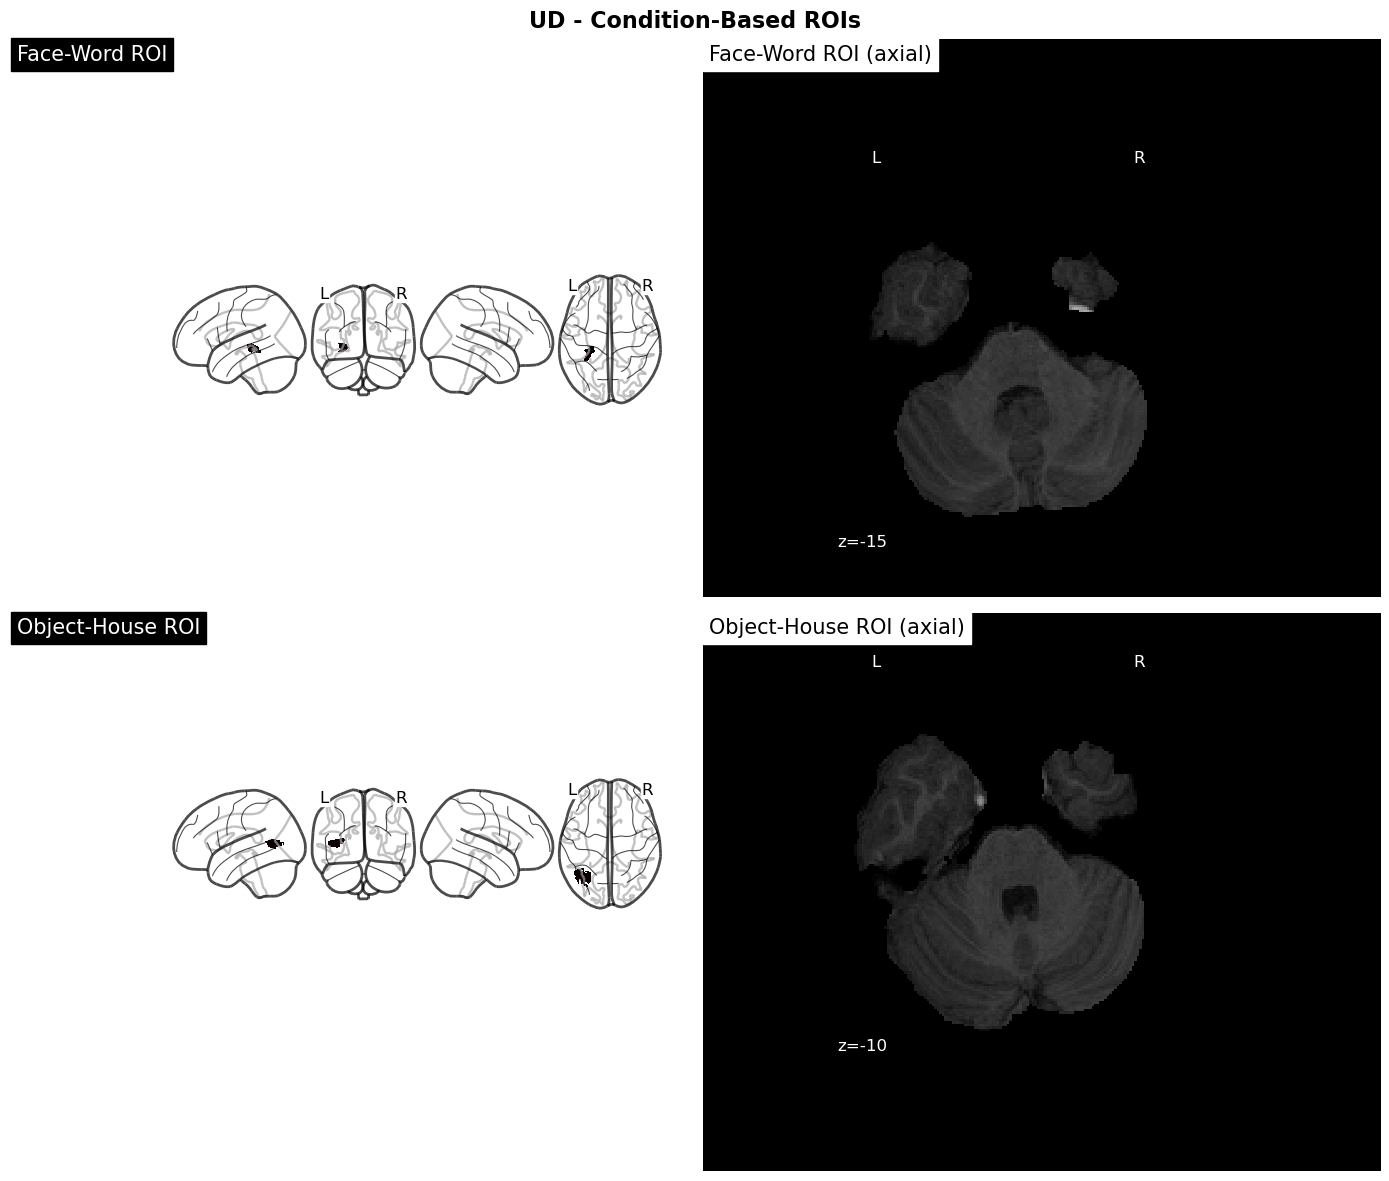

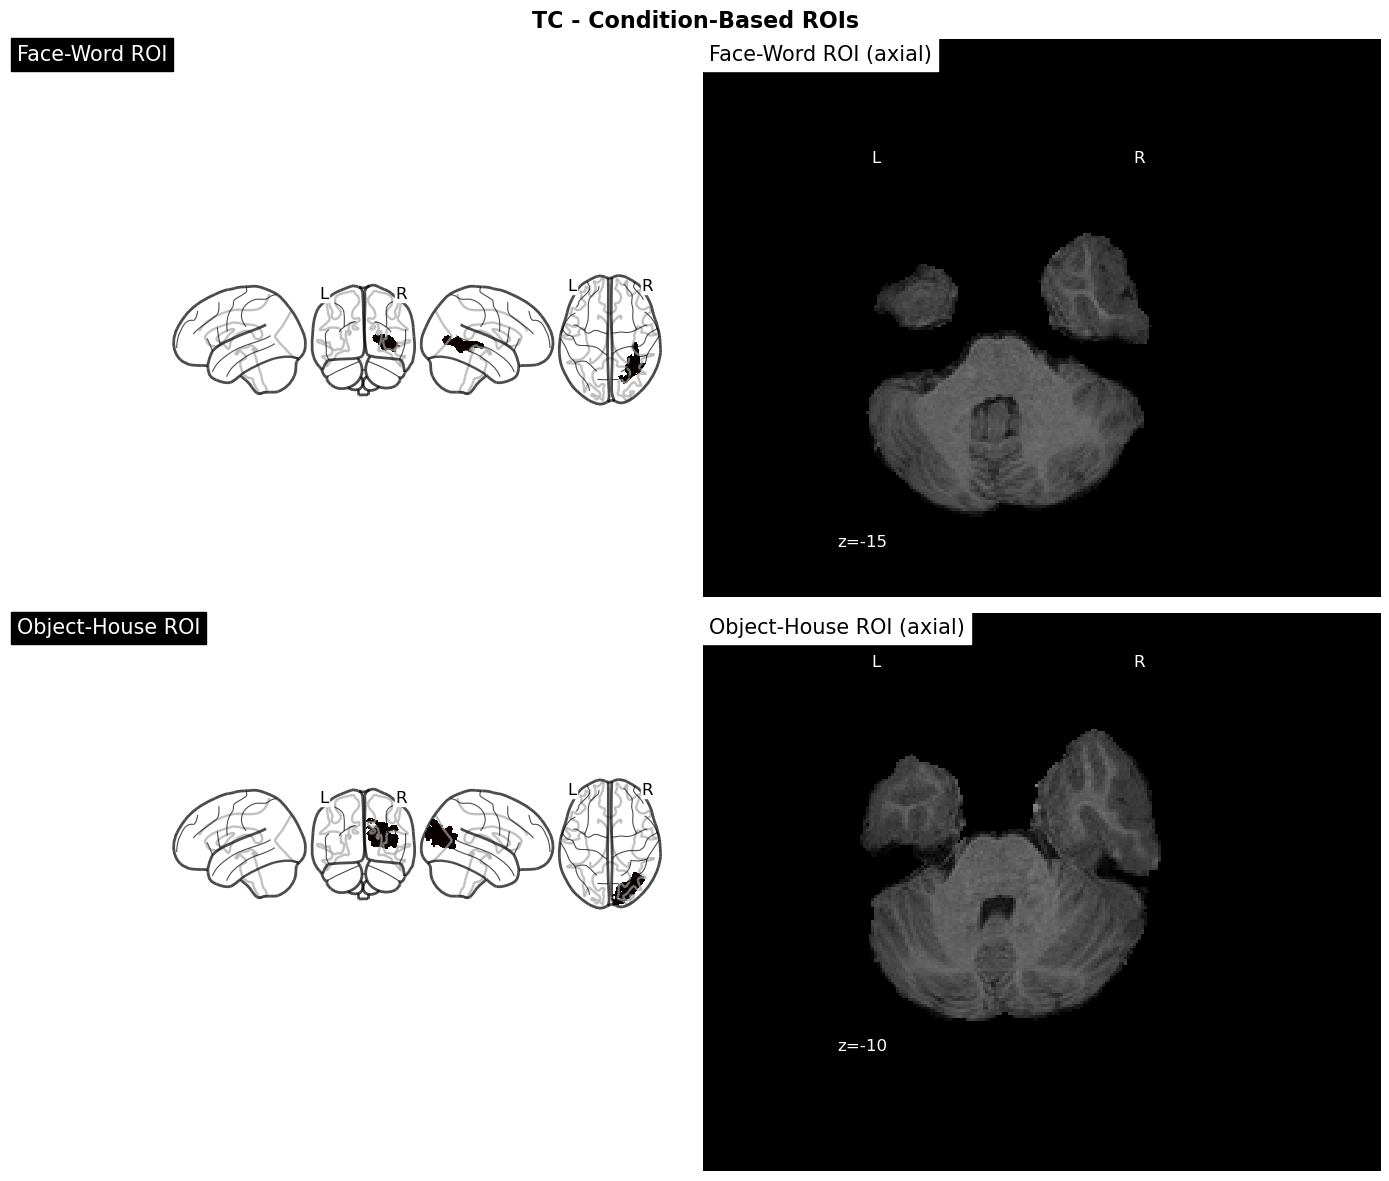

In [2]:
# VISUALIZATION 1: Glass brain showing ROI location

for subject_id in ['sub-004', 'sub-021']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    
    # Face-word ROI
    fw_roi = roi_results[subject_id]['face_word']['mask_file']
    
    plotting.plot_glass_brain(
        fw_roi, axes=axes[0, 0], title='Face-Word ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False
    )
    
    plotting.plot_roi(
        fw_roi, bg_img=anat_file, axes=axes[0, 1],
        title='Face-Word ROI (axial)', display_mode='z',
        cut_coords=[-15], alpha=0.7, cmap='Reds'
    )
    
    # Object-house ROI
    oh_roi = roi_results[subject_id]['object_house']['mask_file']
    
    plotting.plot_glass_brain(
        oh_roi, axes=axes[1, 0], title='Object-House ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False
    )
    
    plotting.plot_roi(
        oh_roi, bg_img=anat_file, axes=axes[1, 1],
        title='Object-House ROI (axial)', display_mode='z',
        cut_coords=[-10], alpha=0.7, cmap='Blues'
    )
    
    fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - Condition-Based ROIs', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_condition_rois_glass.png', dpi=150)
    plt.show()

/tmp/ipykernel_3286020/2982588698.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


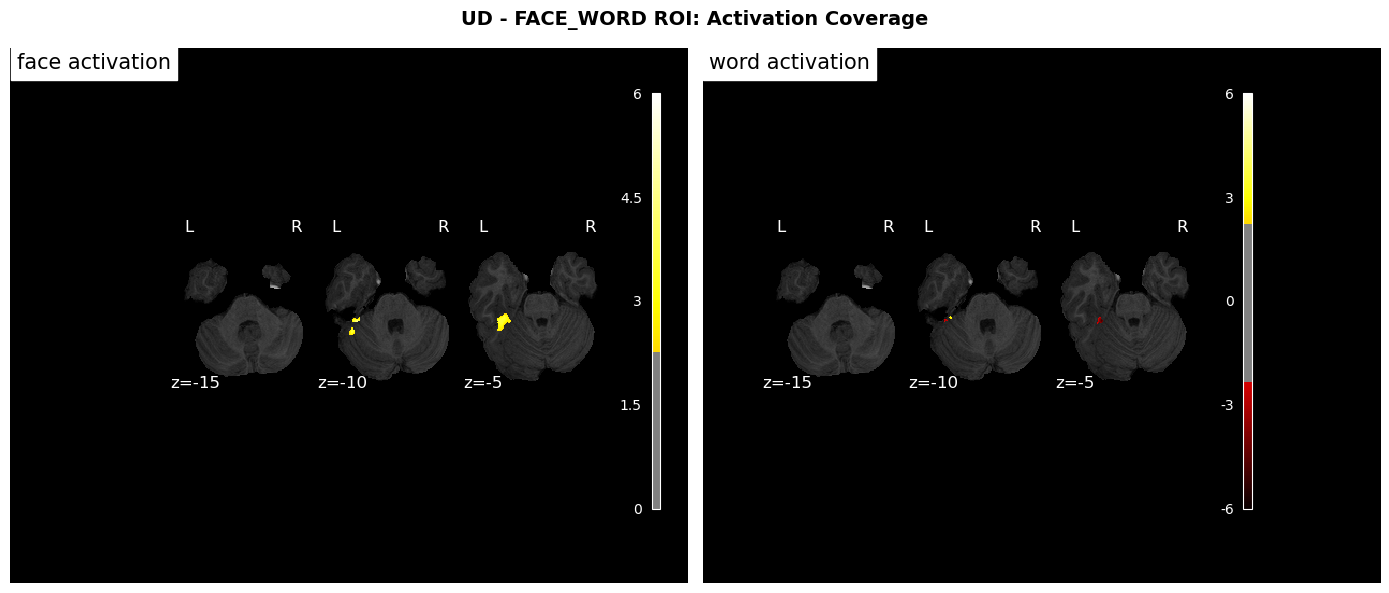

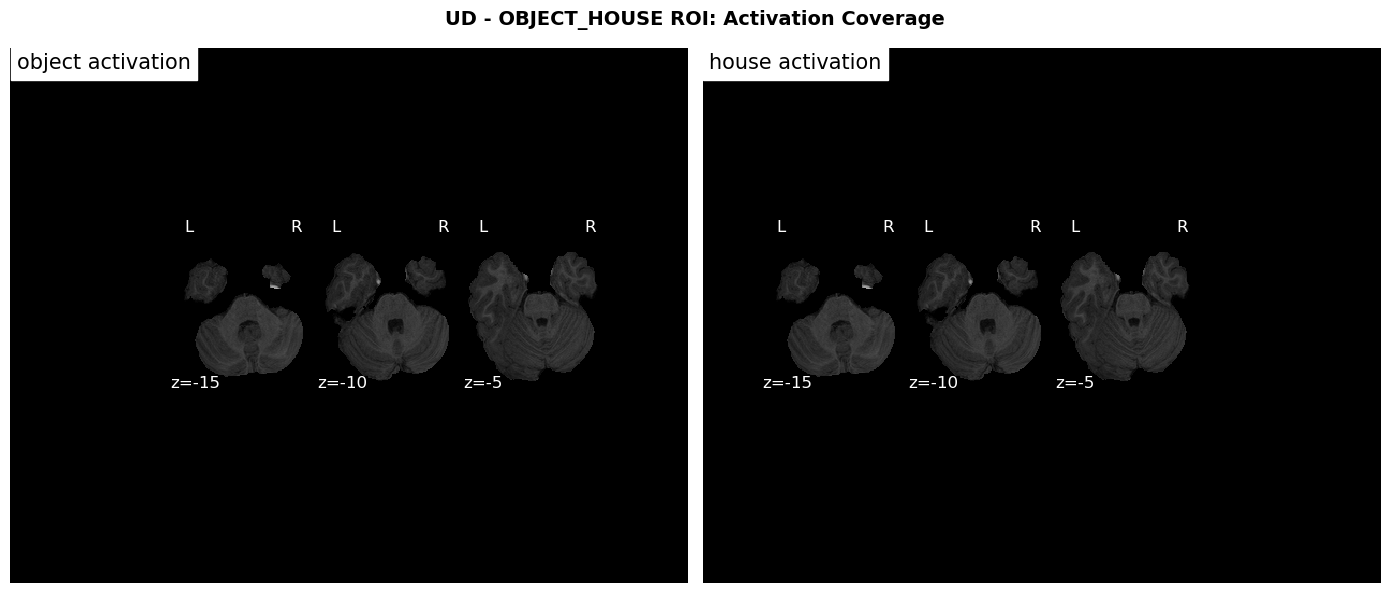

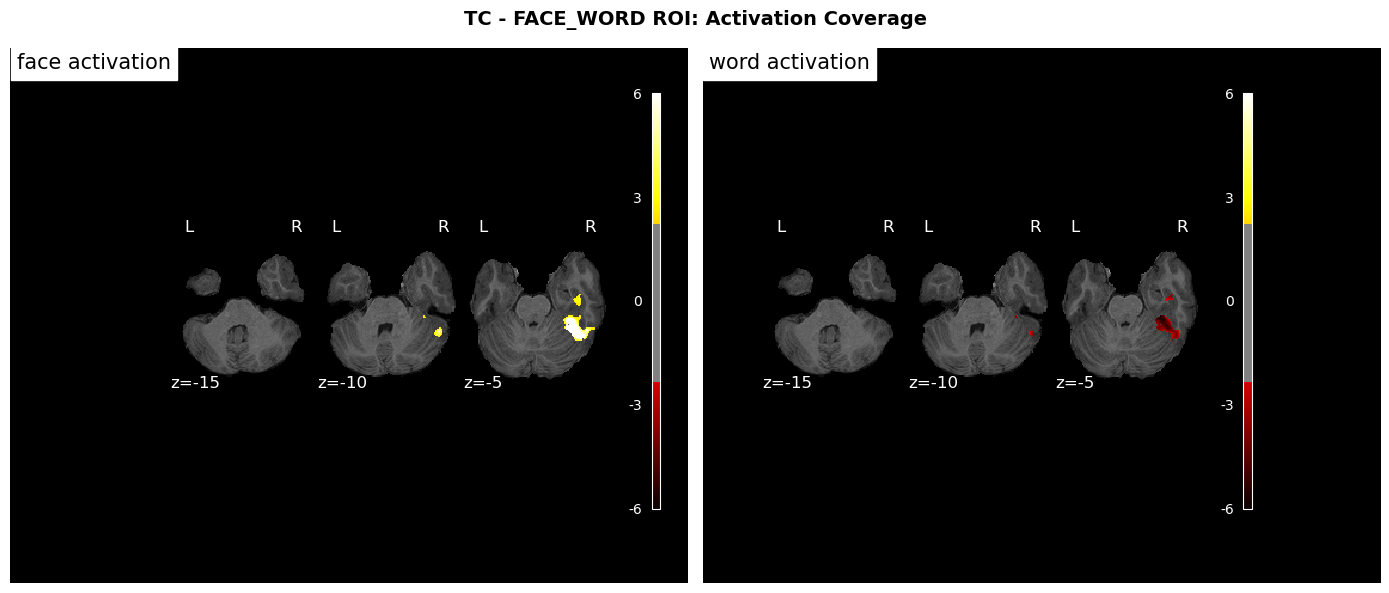

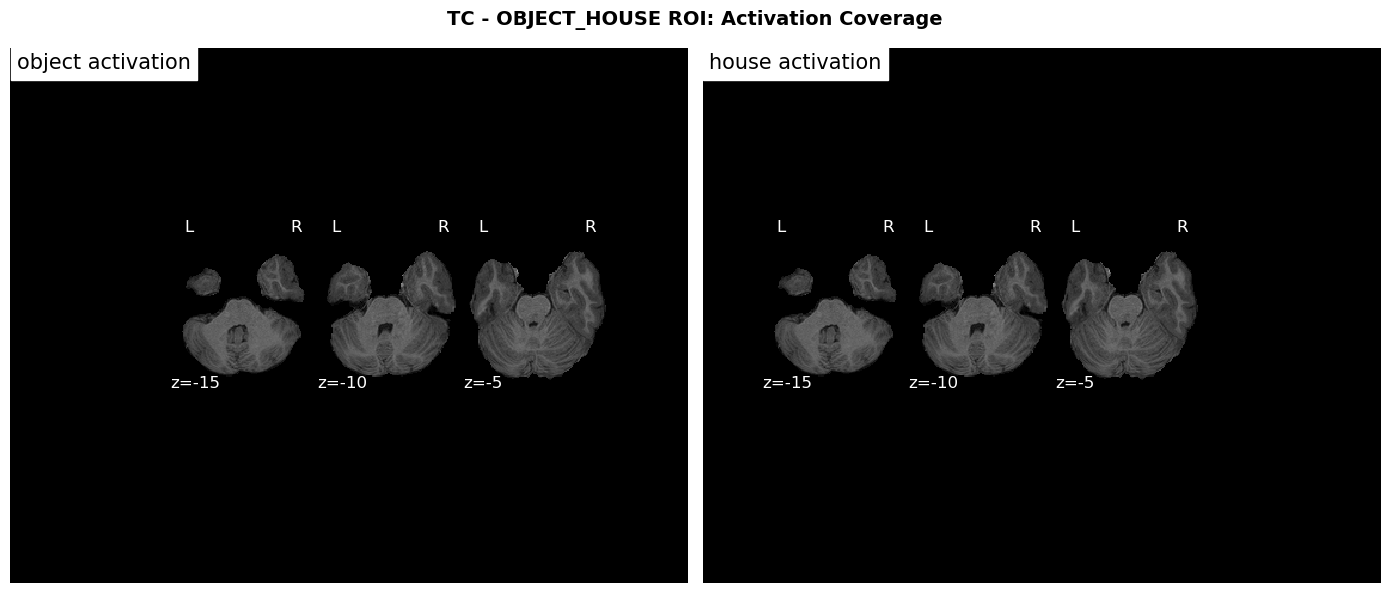

In [3]:
# VISUALIZATION 2: Show activation captured by ROI

for subject_id in ['sub-004', 'sub-021']:
    
    for roi_type in ['face_word', 'object_house']:
        
        result = roi_results[subject_id][roi_type]
        
        # Mask activations by ROI
        roi_mask = result['functional_mask']
        cope1_masked = result['cope1_img'].get_fdata() * roi_mask
        cope2_masked = result['cope2_img'].get_fdata() * roi_mask
        
        cope1_img_masked = nib.Nifti1Image(cope1_masked, result['cope1_img'].affine)
        cope2_img_masked = nib.Nifti1Image(cope2_masked, result['cope2_img'].affine)
        
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Cope 1
        plotting.plot_stat_map(
            cope1_img_masked, bg_img=anat_file, axes=axes[0],
            threshold=2.3, title=f'{roi_type.split("_")[0]} activation',
            display_mode='z', cut_coords=[-15, -10, -5],
            cmap='hot', vmax=6
        )
        
        # Cope 2
        plotting.plot_stat_map(
            cope2_img_masked, bg_img=anat_file, axes=axes[1],
            threshold=2.3, title=f'{roi_type.split("_")[1]} activation',
            display_mode='z', cut_coords=[-15, -10, -5],
            cmap='hot', vmax=6
        )
        
        fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - {roi_type.upper()} ROI: Activation Coverage',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_activation_coverage.png', dpi=150)
        plt.show()

In [15]:
def create_condition_based_roi_v2(subject_id, roi_type='face_word', 
                                   target_percentile=75, min_voxels=8000, max_voxels=15000):
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()}")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope2_num = 6, 9  # face, word
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope2_num = 8, 7  # object, house
    
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # OPTION: Use mean instead of max for balance
    # combined_activation = (cope1_data + cope2_data) / 2
    max_activation = np.maximum(cope1_data, cope2_data)
    
    # Get values within anatomical ROI
    roi_values = max_activation[anat_mask]
    
    # Initialize tracking BEFORE any thresholding
    threshold = np.percentile(roi_values, target_percentile)
    functional_mask = (max_activation > threshold) & anat_mask
    labeled, n_clusters = ndimage.label(functional_mask)
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)] if n_clusters > 0 else [0]
    largest_idx = np.argmax(cluster_sizes) + 1 if n_clusters > 0 else 0
    initial_n_voxels = cluster_sizes[largest_idx - 1] if n_clusters > 0 else 0
    
    adjustment_log = {
        'initial_percentile': target_percentile,
        'initial_threshold': threshold,
        'initial_n_voxels': initial_n_voxels,
        'final_percentile': target_percentile,
        'final_threshold': threshold,
        'final_n_voxels': initial_n_voxels,
        'adjusted': False,
        'reason': None
    }
    
    # Now do adjustments
    if n_clusters > 0:
        functional_mask = (labeled == largest_idx)
        n_voxels = cluster_sizes[largest_idx - 1]
        
        print(f"Threshold: {threshold:.2f} ({target_percentile}th percentile)")
        print(f"Found {n_clusters} clusters, largest: {n_voxels} voxels")
        
        # Adjust if needed
        if n_voxels < min_voxels:
            adjustment_log['adjusted'] = True
            adjustment_log['reason'] = 'too_small'
            print(f"Too small, lowering threshold...")
            new_percentile = target_percentile - 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, n_clusters = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
            
            adjustment_log['final_percentile'] = new_percentile
            adjustment_log['final_threshold'] = threshold
            adjustment_log['final_n_voxels'] = n_voxels
        
        elif n_voxels > max_voxels:
            adjustment_log['adjusted'] = True
            adjustment_log['reason'] = 'too_large'
            print(f"Too large, raising threshold...")
            new_percentile = target_percentile + 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, n_clusters = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
            
            adjustment_log['final_percentile'] = new_percentile
            adjustment_log['final_threshold'] = threshold
            adjustment_log['final_n_voxels'] = n_voxels
        else:
            adjustment_log['final_n_voxels'] = n_voxels
    
    # Get center
    coords = np.where(functional_mask)
    center_vox = [np.mean(c) for c in coords]
    center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
    print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_percentile_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'threshold': threshold,
        'adjustment_log': adjustment_log
    }

# Re-run with percentile approach
roi_results_v2 = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_v2[subject_id] = {}
    roi_results_v2[subject_id]['face_word'] = create_condition_based_roi_v2(subject_id, 'face_word')
    roi_results_v2[subject_id]['object_house'] = create_condition_based_roi_v2(subject_id, 'object_house')

# Check sizes
print("\n" + "="*60)
print("ROI Sizes (Percentile-Based)")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results_v2[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results_v2[subject_id]['object_house']['n_voxels']} voxels")


sub-004 - FACE_WORD
Threshold: 0.89 (75th percentile)
Found 26 clusters, largest: 5089 voxels
Too small, lowering threshold...
Adjusted: 7308 voxels at 65th percentile
Center: (-31.2, -43.5, -2.3)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_percentile_based.nii.gz

sub-004 - OBJECT_HOUSE
Threshold: 1.97 (75th percentile)
Found 33 clusters, largest: 6515 voxels
Too small, lowering threshold...
Adjusted: 10289 voxels at 65th percentile
Center: (-29.3, -74.4, 11.1)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_percentile_based.nii.gz

sub-021 - FACE_WORD
Threshold: 5.53 (75th percentile)
Found 3 clusters, largest: 4476 voxels
Too small, lowering threshold...
Adjusted: 6230 voxels at 65th percentile
Center: (32.4, -53.1, 1.2)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_face_word_percentile_based.nii.gz

sub-021 - OBJECT_HOUSE
Threshold: 4.71 (75th percentile)
Found 9 clusters, largest: 6139 voxels
Too small, lowering threshold...


UD - ROI Composition

Face-Word ROI (7308 voxels):
  Face-selective: 1187 (16.2%)
  Word-selective: 121 (1.7%)
  Both active (z>2.3): 6 (0.1%)
  Mean face activation: 0.73
  Mean word activation: -0.58


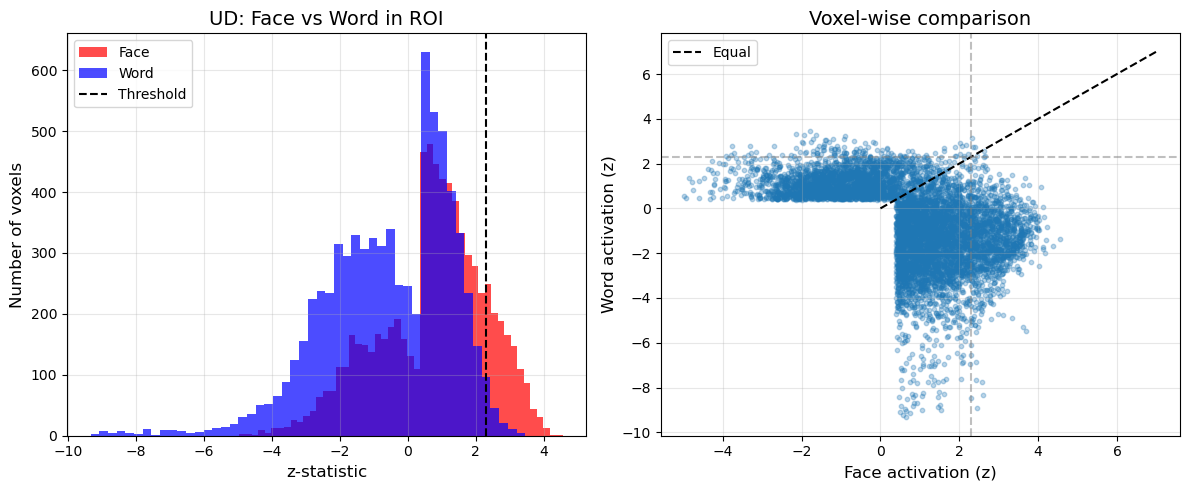


TC - ROI Composition

Face-Word ROI (6230 voxels):
  Face-selective: 6230 (100.0%)
  Word-selective: 0 (0.0%)
  Both active (z>2.3): 6 (0.1%)
  Mean face activation: 8.14
  Mean word activation: -3.59


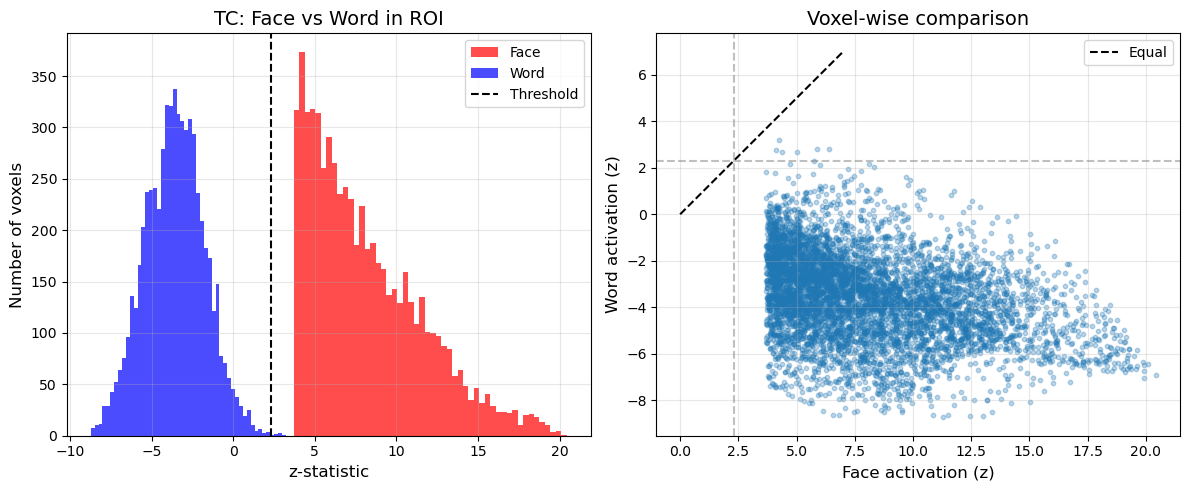

In [16]:
# Check face vs word dominance in final ROIs

for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{'='*60}")
    print(f"{SUBJECTS[subject_id]['code']} - ROI Composition")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load final face_word ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_word_percentile_based.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    
    # Load face and word activations
    face_img = nib.load(BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                        'HighLevel.gfeat' / 'cope6.feat' / 'stats' / 'zstat1.nii.gz')
    word_img = nib.load(BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                        'HighLevel.gfeat' / 'cope9.feat' / 'stats' / 'zstat1.nii.gz')
    
    face_data = face_img.get_fdata()[roi_mask]
    word_data = word_img.get_fdata()[roi_mask]
    
    # Categorize voxels
    face_selective = (face_data > word_data) & (face_data > 2.3)
    word_selective = (word_data > face_data) & (word_data > 2.3)
    both_active = (face_data > 2.3) & (word_data > 2.3)
    
    print(f"\nFace-Word ROI ({np.sum(roi_mask)} voxels):")
    print(f"  Face-selective: {np.sum(face_selective)} ({100*np.sum(face_selective)/len(face_data):.1f}%)")
    print(f"  Word-selective: {np.sum(word_selective)} ({100*np.sum(word_selective)/len(word_data):.1f}%)")
    print(f"  Both active (z>2.3): {np.sum(both_active)} ({100*np.sum(both_active)/len(face_data):.1f}%)")
    print(f"  Mean face activation: {face_data.mean():.2f}")
    print(f"  Mean word activation: {word_data.mean():.2f}")
    
    # Histogram comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(face_data, bins=50, alpha=0.7, label='Face', color='red')
    axes[0].hist(word_data, bins=50, alpha=0.7, label='Word', color='blue')
    axes[0].axvline(2.3, color='black', linestyle='--', label='Threshold')
    axes[0].set_xlabel('z-statistic', fontsize=12)
    axes[0].set_ylabel('Number of voxels', fontsize=12)
    axes[0].set_title(f'{SUBJECTS[subject_id]["code"]}: Face vs Word in ROI', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot
    axes[1].scatter(face_data, word_data, alpha=0.3, s=10)
    axes[1].plot([0, 7], [0, 7], 'k--', label='Equal')
    axes[1].axhline(2.3, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(2.3, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Face activation (z)', fontsize=12)
    axes[1].set_ylabel('Word activation (z)', fontsize=12)
    axes[1].set_title('Voxel-wise comparison', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_face_word_balance.png', dpi=150)
    plt.show()

In [13]:
def create_condition_based_roi_v2(subject_id, roi_type='face_word', 
                                   target_percentile=75, min_voxels=8000, max_voxels=15000):
    """
    Create ROI using percentile threshold within anatomical constraint
    Ensures more consistent sizes across subjects
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()}")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope2_num = 6, 9  # face, word
    else:
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope2_num = 8, 7  # object, house
    
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # Take maximum activation of the two conditions
    max_activation = np.maximum(cope1_data, cope2_data)
    
    # Get values within anatomical ROI
    roi_values = max_activation[anat_mask]
    
    # Use percentile to set threshold
    threshold = np.percentile(roi_values, target_percentile)
    
    functional_mask = (max_activation > threshold) & anat_mask
    
    # Find largest cluster
    labeled, n_clusters = ndimage.label(functional_mask)
    
    if n_clusters > 0:
        cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
        largest_idx = np.argmax(cluster_sizes) + 1
        functional_mask = (labeled == largest_idx)
        n_voxels = cluster_sizes[largest_idx - 1]
        
        print(f"Threshold: {threshold:.2f} ({target_percentile}th percentile)")
        print(f"Found {n_clusters} clusters, largest: {n_voxels} voxels")
        
        # Adjust if outside target range
        if n_voxels < min_voxels:
            print(f"Too small, lowering threshold...")
            new_percentile = target_percentile - 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, _ = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
        
        elif n_voxels > max_voxels:
            print(f"Too large, raising threshold...")
            new_percentile = target_percentile + 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (max_activation > threshold) & anat_mask
            labeled, _ = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile")
    
    # Get center
    coords = np.where(functional_mask)
    center_vox = [np.mean(c) for c in coords]
    center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
    print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_percentile_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'threshold': threshold
    }

# Re-run with percentile approach
roi_results_v2 = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_v2[subject_id] = {}
    roi_results_v2[subject_id]['face_word'] = create_condition_based_roi_v2(subject_id, 'face_word')
    roi_results_v2[subject_id]['object_house'] = create_condition_based_roi_v2(subject_id, 'object_house')

# Check sizes
print("\n" + "="*60)
print("ROI Sizes (Percentile-Based)")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results_v2[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results_v2[subject_id]['object_house']['n_voxels']} voxels")


sub-004 - FACE_WORD
Threshold: 0.89 (75th percentile)
Found 26 clusters, largest: 5089 voxels
Too small, lowering threshold...
Adjusted: 7308 voxels at 65th percentile
Center: (-31.2, -43.5, -2.3)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_percentile_based.nii.gz

sub-004 - OBJECT_HOUSE
Threshold: 1.97 (75th percentile)
Found 33 clusters, largest: 6515 voxels
Too small, lowering threshold...
Adjusted: 10289 voxels at 65th percentile
Center: (-29.3, -74.4, 11.1)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_percentile_based.nii.gz

sub-021 - FACE_WORD
Threshold: 5.53 (75th percentile)
Found 3 clusters, largest: 4476 voxels
Too small, lowering threshold...
Adjusted: 6230 voxels at 65th percentile
Center: (32.4, -53.1, 1.2)
Saved: /user_data/csimmon2/long_pt/sub-021/ses-01/ROIs/r_face_word_percentile_based.nii.gz

sub-021 - OBJECT_HOUSE
Threshold: 4.71 (75th percentile)
Found 9 clusters, largest: 6139 voxels
Too small, lowering threshold...

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/tmp/ipykernel_3286020/724759063.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


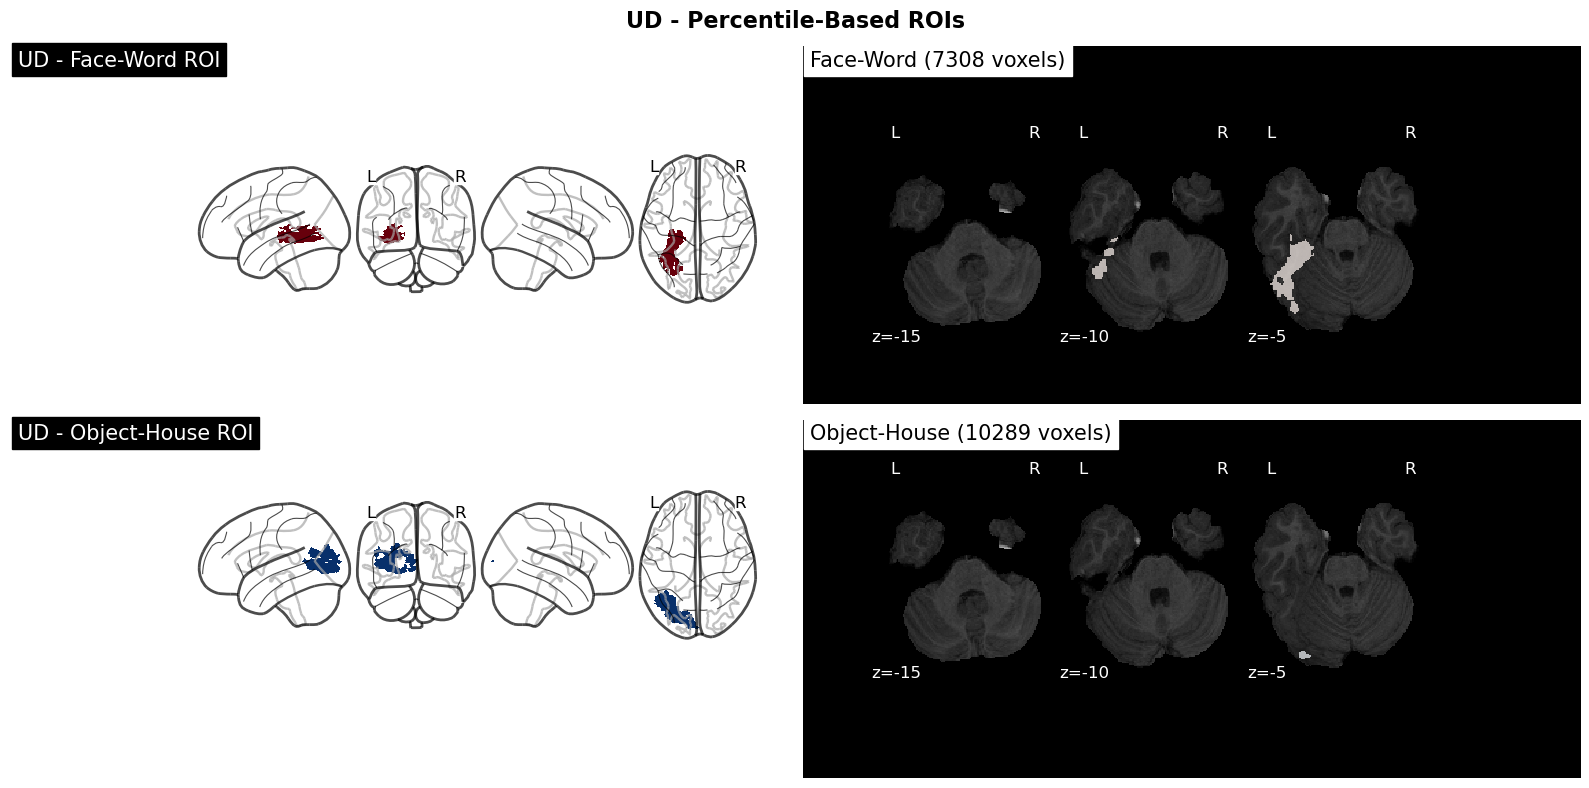

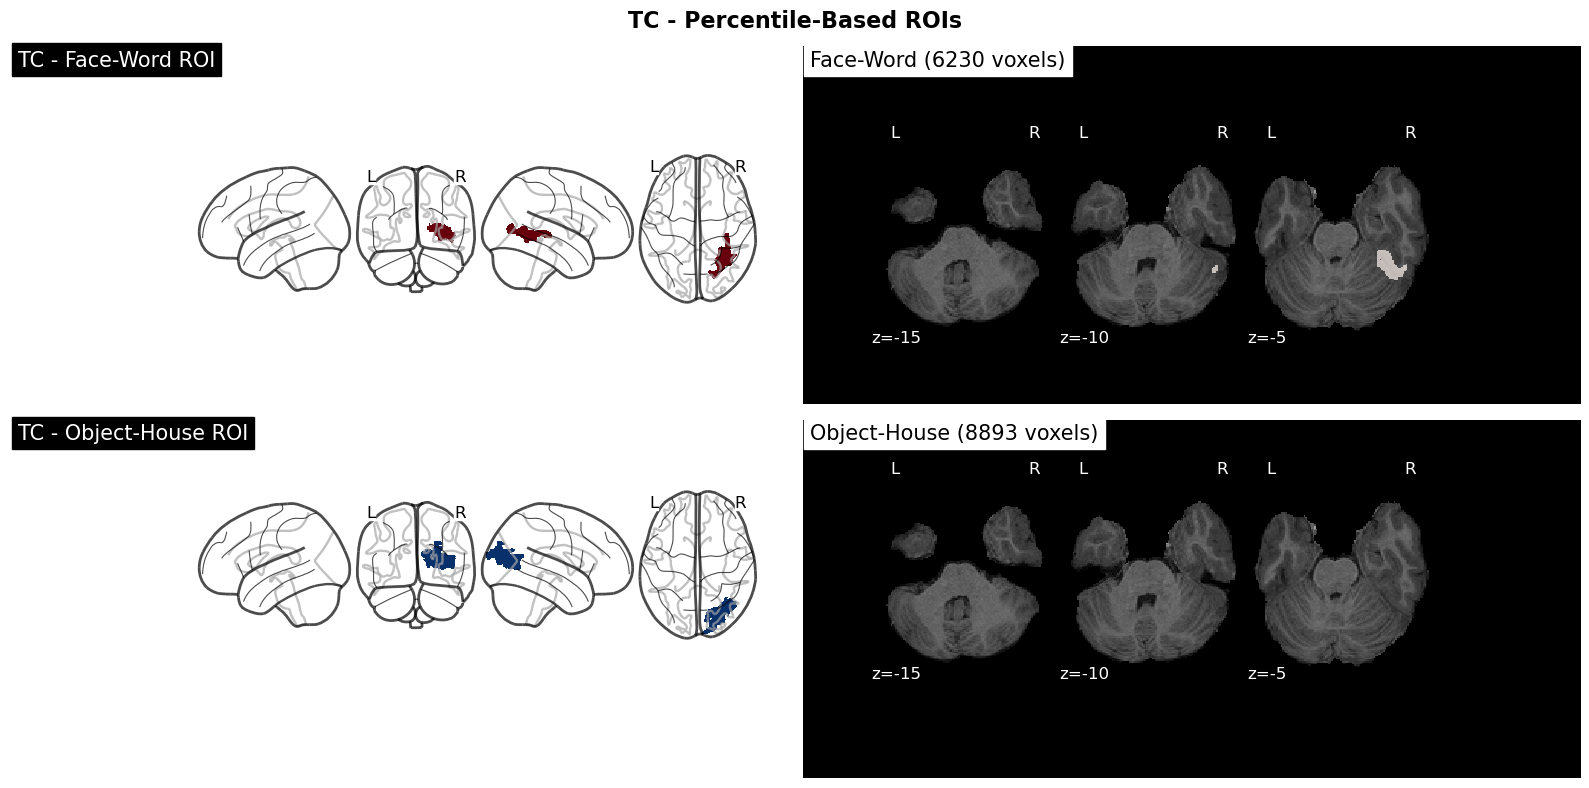

In [ ]:
# Glass brain visualization for percentile-based ROIs

for subject_id in ['sub-004', 'sub-021']:
    
    fig = plt.figure(figsize=(16, 8))
    
    # Face-word ROI
    fw_roi = roi_results_v2[subject_id]['face_word']['mask_file']
    
    # Glass brain - face-word
    ax1 = plt.subplot(2, 2, 1)
    plotting.plot_glass_brain(
        fw_roi, axes=ax1, title=f'{SUBJECTS[subject_id]["code"]} - Face-Word ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False, cmap='Reds'
    )
    
    # Axial view - face-word
    ax2 = plt.subplot(2, 2, 2)
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    plotting.plot_roi(
        fw_roi, bg_img=anat_file, axes=ax2,
        title=f'Face-Word ({roi_results_v2[subject_id]["face_word"]["n_voxels"]} voxels)',
        display_mode='z', cut_coords=[-15, -10, -5],
        alpha=0.7, cmap='Reds'
    )
    
    # Object-house ROI
    oh_roi = roi_results_v2[subject_id]['object_house']['mask_file']
    
    # Glass brain - object-house
    ax3 = plt.subplot(2, 2, 3)
    plotting.plot_glass_brain(
        oh_roi, axes=ax3, title=f'{SUBJECTS[subject_id]["code"]} - Object-House ROI',
        display_mode='lyrz', colorbar=False, plot_abs=False, cmap='Blues'
    )
    
    # Axial view - object-house
    ax4 = plt.subplot(2, 2, 4)
    plotting.plot_roi(
        oh_roi, bg_img=anat_file, axes=ax4,
        title=f'Object-House ({roi_results_v2[subject_id]["object_house"]["n_voxels"]} voxels)',
        display_mode='z', cut_coords=[-15, -10, -5],
        alpha=0.7, cmap='Blues'
    )
    
    plt.suptitle(f'{SUBJECTS[subject_id]["code"]} - Percentile-Based ROIs', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_percentile_rois_glass.png', dpi=150)
    plt.show()

Creating surface plot for sub-004...


<Figure size 1200x500 with 0 Axes>

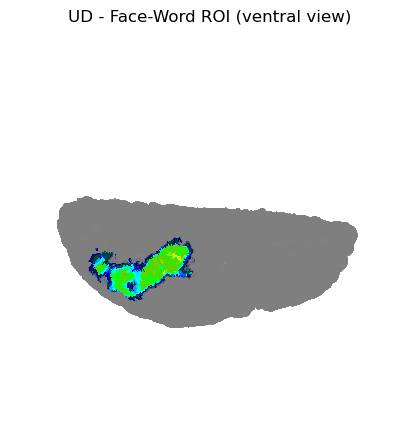

In [9]:
# FIXED: Surface plot with correct hemisphere parameter

from nilearn import surface

for subject_id in ['sub-004']:  # Start with one
    hemi_code = SUBJECTS[subject_id]['hemi']  # 'l' or 'r'
    hemi_str = 'lh' if hemi_code == 'l' else 'rh'
    hemi_full = 'left' if hemi_code == 'l' else 'right'  # For nilearn
    
    fs_subject = f'{subject_id}_ses-01'
    fs_dir = Path('/lab_data/behrmannlab/hemi/FS')
    
    # Check if surface exists
    pial_file = fs_dir / fs_subject / 'surf' / f'{hemi_str}.pial'
    
    if pial_file.exists():
        print(f"Creating surface plot for {subject_id}...")
        
        # Load surface
        surf_mesh = str(pial_file)
        
        # Project ROI to surface
        fw_roi = roi_results_v2[subject_id]['face_word']['mask_file']
        texture = surface.vol_to_surf(str(fw_roi), surf_mesh)
        
        # Plot
        fig = plt.figure(figsize=(12, 5))
        
        plotting.plot_surf_roi(surf_mesh, roi_map=texture,
                              hemi=hemi_full,  # FIXED: use 'left' not 'l'
                              view='ventral', bg_map=None,
                              title=f'{SUBJECTS[subject_id]["code"]} - Face-Word ROI (ventral view)')
        
        plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_surface_roi.png', dpi=150)
        plt.show()
    else:
        print(f"Surface file not found: {pial_file}")

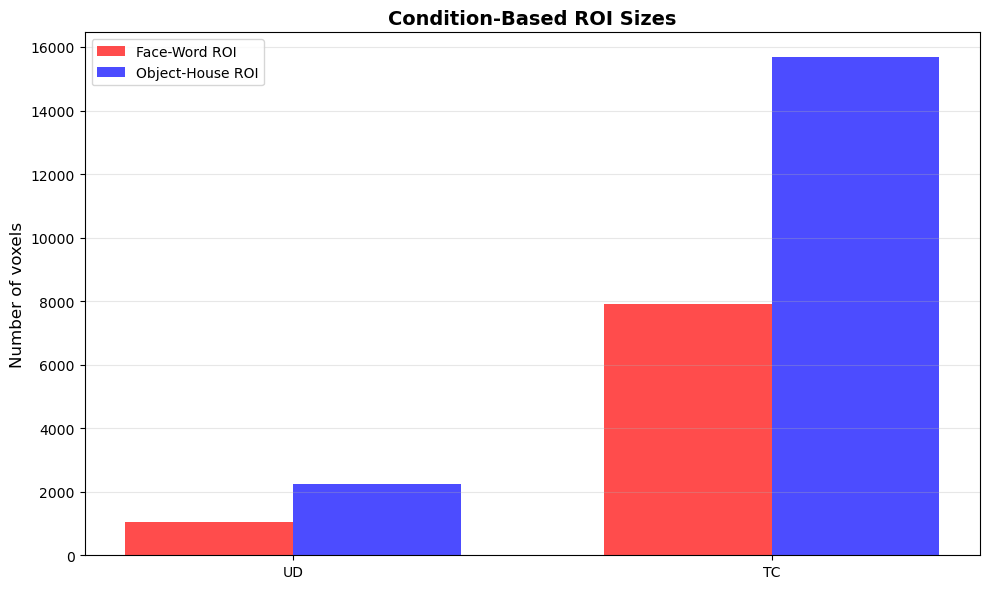


ROI Creation Complete!

UD:
  Face-Word: 1057 voxels
  Object-House: 2236 voxels

TC:
  Face-Word: 7900 voxels
  Object-House: 15677 voxels


In [5]:
# VISUALIZATION 4: ROI size comparison

fig, ax = plt.subplots(figsize=(10, 6))

subjects = ['sub-004', 'sub-021']
x = np.arange(len(subjects))
width = 0.35

fw_sizes = [roi_results[s]['face_word']['n_voxels'] for s in subjects]
oh_sizes = [roi_results[s]['object_house']['n_voxels'] for s in subjects]

ax.bar(x - width/2, fw_sizes, width, label='Face-Word ROI', color='red', alpha=0.7)
ax.bar(x + width/2, oh_sizes, width, label='Object-House ROI', color='blue', alpha=0.7)

ax.set_ylabel('Number of voxels', fontsize=12)
ax.set_title('Condition-Based ROI Sizes', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([SUBJECTS[s]['code'] for s in subjects])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'roi_size_comparison.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("ROI Creation Complete!")
print("="*60)
for subject_id in subjects:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results[subject_id]['object_house']['n_voxels']} voxels")

In [17]:
def create_contrast_based_roi(subject_id, roi_type='face_word', 
                              abs_threshold=2.3, target_percentile=70, 
                              min_voxels=8000, max_voxels=15000):
    """
    Create ROI from contrast selectivity (|face-word| or |object-house|)
    Captures voxels with strong selectivity in EITHER direction
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()} (Contrast-Based)")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and contrast cope
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        contrast_cope = 13  # face-word
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        contrast_cope = 14  # object-house
    
    # Load anatomical mask
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load contrast
    contrast_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                   'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
    
    contrast_img = nib.load(contrast_file)
    contrast_data = contrast_img.get_fdata()
    
    # Use ABSOLUTE VALUE - captures both directions of selectivity
    abs_contrast = np.abs(contrast_data)
    
    # Get values within anatomical ROI
    roi_values = abs_contrast[anat_mask]
    
    # Use percentile for threshold
    threshold = np.percentile(roi_values, target_percentile)
    
    # Ensure minimum absolute threshold
    if threshold < abs_threshold:
        threshold = abs_threshold
        print(f"Using minimum threshold: {threshold:.2f}")
    
    functional_mask = (abs_contrast > threshold) & anat_mask
    
    # Find largest cluster
    labeled, n_clusters = ndimage.label(functional_mask)
    
    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)] if n_clusters > 0 else [0]
    largest_idx = np.argmax(cluster_sizes) + 1 if n_clusters > 0 else 0
    initial_n_voxels = cluster_sizes[largest_idx - 1] if n_clusters > 0 else 0
    
    # Tracking
    adjustment_log = {
        'initial_percentile': target_percentile,
        'initial_threshold': threshold,
        'initial_n_voxels': initial_n_voxels,
        'final_percentile': target_percentile,
        'final_threshold': threshold,
        'final_n_voxels': initial_n_voxels,
        'adjusted': False,
        'reason': None
    }
    
    if n_clusters > 0:
        functional_mask = (labeled == largest_idx)
        n_voxels = cluster_sizes[largest_idx - 1]
        
        print(f"Threshold: |z| > {threshold:.2f} ({target_percentile}th percentile)")
        print(f"Found {n_clusters} clusters, largest: {n_voxels} voxels")
        
        # Adjust if needed
        if n_voxels < min_voxels:
            adjustment_log['adjusted'] = True
            adjustment_log['reason'] = 'too_small'
            print(f"Too small, lowering threshold...")
            new_percentile = target_percentile - 10
            threshold = np.percentile(roi_values, new_percentile)
            if threshold < abs_threshold:
                threshold = abs_threshold
            functional_mask = (abs_contrast > threshold) & anat_mask
            labeled, n_clusters = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile, |z|>{threshold:.2f}")
            
            adjustment_log['final_percentile'] = new_percentile
            adjustment_log['final_threshold'] = threshold
            adjustment_log['final_n_voxels'] = n_voxels
        
        elif n_voxels > max_voxels:
            adjustment_log['adjusted'] = True
            adjustment_log['reason'] = 'too_large'
            print(f"Too large, raising threshold...")
            new_percentile = target_percentile + 10
            threshold = np.percentile(roi_values, new_percentile)
            functional_mask = (abs_contrast > threshold) & anat_mask
            labeled, n_clusters = ndimage.label(functional_mask)
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            functional_mask = (labeled == largest_idx)
            n_voxels = cluster_sizes[largest_idx - 1]
            print(f"Adjusted: {n_voxels} voxels at {new_percentile}th percentile, |z|>{threshold:.2f}")
            
            adjustment_log['final_percentile'] = new_percentile
            adjustment_log['final_threshold'] = threshold
            adjustment_log['final_n_voxels'] = n_voxels
        else:
            adjustment_log['final_n_voxels'] = n_voxels
        
        # Count face vs word selective voxels
        actual_contrast = contrast_data[functional_mask]
        face_selective = np.sum(actual_contrast > 0)
        word_selective = np.sum(actual_contrast < 0)
        
        print(f"Face-selective: {face_selective} ({100*face_selective/n_voxels:.1f}%)")
        print(f"Word-selective: {word_selective} ({100*word_selective/n_voxels:.1f}%)")
    
    # Get center
    coords = np.where(functional_mask)
    center_vox = [np.mean(c) for c in coords]
    center_world = nib.affines.apply_affine(contrast_img.affine, center_vox)
    print(f"Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_contrast_based.nii.gz'
    functional_img = nib.Nifti1Image(functional_mask.astype(np.float32), anat_roi.affine)
    nib.save(functional_img, output_file)
    print(f"Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_voxels': n_voxels,
        'threshold': threshold,
        'adjustment_log': adjustment_log,
        'contrast_data': contrast_data,
        'functional_mask': functional_mask
    }

# Create contrast-based ROIs
roi_results_contrast = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_contrast[subject_id] = {}
    roi_results_contrast[subject_id]['face_word'] = create_contrast_based_roi(subject_id, 'face_word')
    roi_results_contrast[subject_id]['object_house'] = create_contrast_based_roi(subject_id, 'object_house')

# Summary
print("\n" + "="*60)
print("CONTRAST-BASED ROI SIZES")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    print(f"  Face-Word: {roi_results_contrast[subject_id]['face_word']['n_voxels']} voxels")
    print(f"  Object-House: {roi_results_contrast[subject_id]['object_house']['n_voxels']} voxels")


sub-004 - FACE_WORD (Contrast-Based)
Threshold: |z| > 2.31 (70th percentile)
Found 18 clusters, largest: 6575 voxels
Too small, lowering threshold...
Adjusted: 6603 voxels at 60th percentile, |z|>2.30
Face-selective: 6603 (100.0%)
Word-selective: 0 (0.0%)
Center: (-25.8, -49.4, -2.0)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_contrast_based.nii.gz

sub-004 - OBJECT_HOUSE (Contrast-Based)
Using minimum threshold: 2.30
Threshold: |z| > 2.30 (70th percentile)
Found 14 clusters, largest: 3030 voxels
Too small, lowering threshold...
Adjusted: 3030 voxels at 60th percentile, |z|>2.30
Face-selective: 3030 (100.0%)
Word-selective: 0 (0.0%)
Center: (-15.4, -83.4, 6.9)
Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_contrast_based.nii.gz

sub-021 - FACE_WORD (Contrast-Based)
Threshold: |z| > 2.40 (70th percentile)
Found 10 clusters, largest: 4094 voxels
Too small, lowering threshold...
Adjusted: 4284 voxels at 60th percentile, |z|>2.30
Face-selectiv

In [18]:
def create_dual_cluster_roi(subject_id, roi_type='face_word', 
                           target_percentile=75, min_voxels_per_category=3000):
    """
    Create ROI from TWO separate clusters (face AND word, or object AND house)
    Combine via union to ensure both categories represented
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()} (Dual-Cluster)")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and individual condition copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 6, 'face'  # face>all
        cope2_num, cope2_name = 9, 'word'  # word>all
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 8, 'object'  # object>all
        cope2_num, cope2_name = 7, 'house'   # house>all
    
    # Load anatomical mask
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load individual conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # === CLUSTER 1 (e.g., face) ===
    print(f"\nFinding {cope1_name} cluster...")
    roi1_values = cope1_data[anat_mask]
    threshold1 = np.percentile(roi1_values, target_percentile)
    
    mask1 = (cope1_data > threshold1) & anat_mask
    labeled1, n_clusters1 = ndimage.label(mask1)
    
    if n_clusters1 > 0:
        cluster_sizes1 = [(labeled1 == i).sum() for i in range(1, n_clusters1 + 1)]
        largest_idx1 = np.argmax(cluster_sizes1) + 1
        cluster1_mask = (labeled1 == largest_idx1)
        n_vox1 = cluster_sizes1[largest_idx1 - 1]
        print(f"  {cope1_name}: {n_vox1} voxels (threshold z>{threshold1:.2f})")
    else:
        cluster1_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox1 = 0
        print(f"  {cope1_name}: No clusters found")
    
    # === CLUSTER 2 (e.g., word) ===
    print(f"Finding {cope2_name} cluster...")
    roi2_values = cope2_data[anat_mask]
    threshold2 = np.percentile(roi2_values, target_percentile)
    
    mask2 = (cope2_data > threshold2) & anat_mask
    labeled2, n_clusters2 = ndimage.label(mask2)
    
    if n_clusters2 > 0:
        cluster_sizes2 = [(labeled2 == i).sum() for i in range(1, n_clusters2 + 1)]
        largest_idx2 = np.argmax(cluster_sizes2) + 1
        cluster2_mask = (labeled2 == largest_idx2)
        n_vox2 = cluster_sizes2[largest_idx2 - 1]
        print(f"  {cope2_name}: {n_vox2} voxels (threshold z>{threshold2:.2f})")
    else:
        cluster2_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox2 = 0
        print(f"  {cope2_name}: No clusters found")
    
    # === UNION (no double counting) ===
    combined_mask = cluster1_mask | cluster2_mask
    n_total = np.sum(combined_mask)
    n_overlap = np.sum(cluster1_mask & cluster2_mask)
    
    print(f"\nCombined ROI:")
    print(f"  Total: {n_total} voxels")
    print(f"  {cope1_name} only: {n_vox1 - n_overlap}")
    print(f"  {cope2_name} only: {n_vox2 - n_overlap}")
    print(f"  Overlap: {n_overlap}")
    
    # Get center
    if n_total > 0:
        coords = np.where(combined_mask)
        center_vox = [np.mean(c) for c in coords]
        center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
        print(f"  Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    combined_img = nib.Nifti1Image(combined_mask.astype(np.float32), anat_roi.affine)
    nib.save(combined_img, output_file)
    print(f"  Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_total': n_total,
        'n_cluster1': n_vox1,
        'n_cluster2': n_vox2,
        'n_overlap': n_overlap,
        'cluster1_mask': cluster1_mask,
        'cluster2_mask': cluster2_mask
    }

# Create dual-cluster ROIs
roi_results_dual = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_dual[subject_id] = {}
    roi_results_dual[subject_id]['face_word'] = create_dual_cluster_roi(subject_id, 'face_word')
    roi_results_dual[subject_id]['object_house'] = create_dual_cluster_roi(subject_id, 'object_house')

# Summary
print("\n" + "="*60)
print("DUAL-CLUSTER ROI SUMMARY")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    fw = roi_results_dual[subject_id]['face_word']
    oh = roi_results_dual[subject_id]['object_house']
    print(f"  Face-Word: {fw['n_total']} voxels (face={fw['n_cluster1']}, word={fw['n_cluster2']}, overlap={fw['n_overlap']})")
    print(f"  Object-House: {oh['n_total']} voxels (object={oh['n_cluster1']}, house={oh['n_cluster2']}, overlap={oh['n_overlap']})")


sub-004 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 5024 voxels (threshold z>0.35)
Finding word cluster...
  word: 3891 voxels (threshold z>0.00)

Combined ROI:
  Total: 8023 voxels
  face only: 4132
  word only: 2999
  Overlap: 892
  Center: (-31.3, -44.1, -2.0)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_dual_cluster.nii.gz

sub-004 - OBJECT_HOUSE (Dual-Cluster)

Finding object cluster...
  object: 6944 voxels (threshold z>1.86)
Finding house cluster...
  house: 7634 voxels (threshold z>0.39)

Combined ROI:
  Total: 13734 voxels
  object only: 6100
  house only: 6790
  Overlap: 844
  Center: (-24.7, -77.2, 13.3)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_dual_cluster.nii.gz

sub-021 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 4476 voxels (threshold z>5.53)
Finding word cluster...
  word: 2123 voxels (threshold z>-1.04)

Combined ROI:
  Total: 6366 voxels
  face only: 4243
  word only: 1890
  Overla

/tmp/ipykernel_3286020/485166046.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


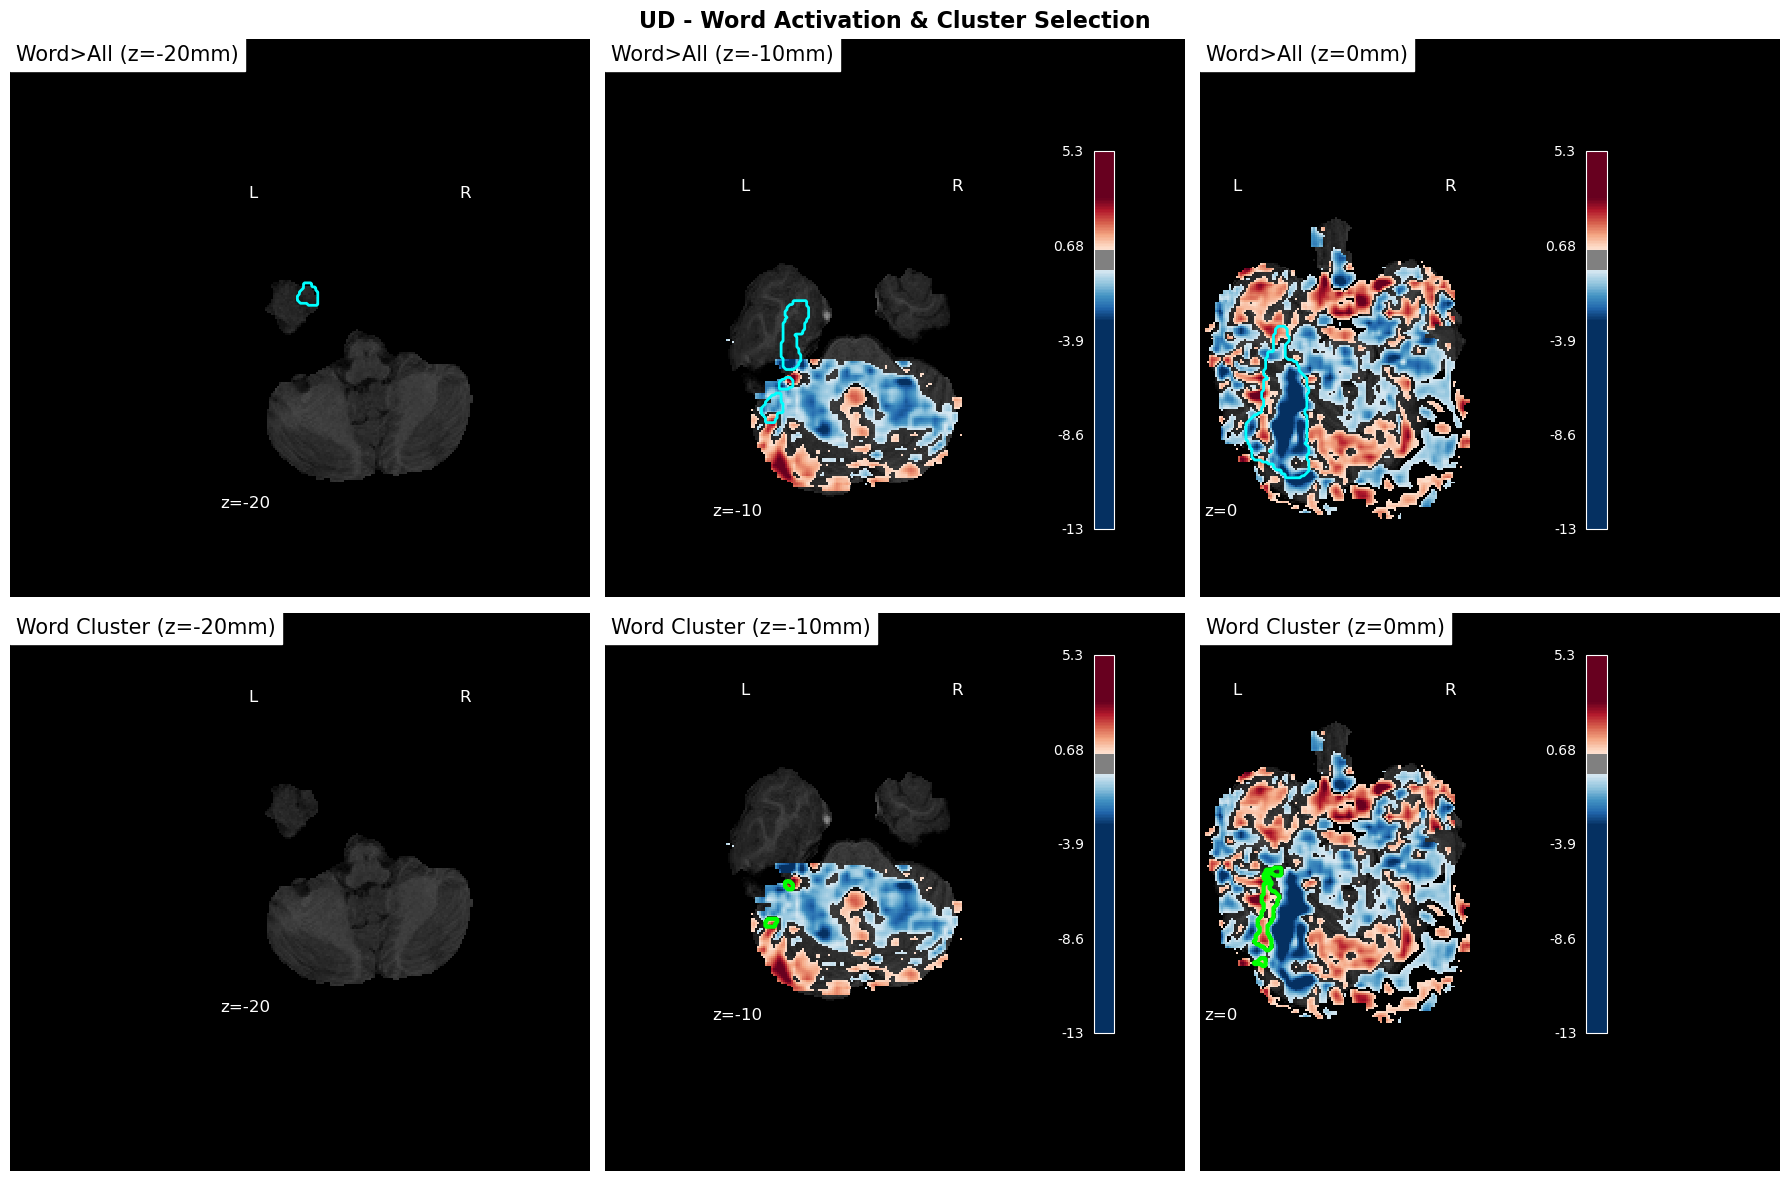

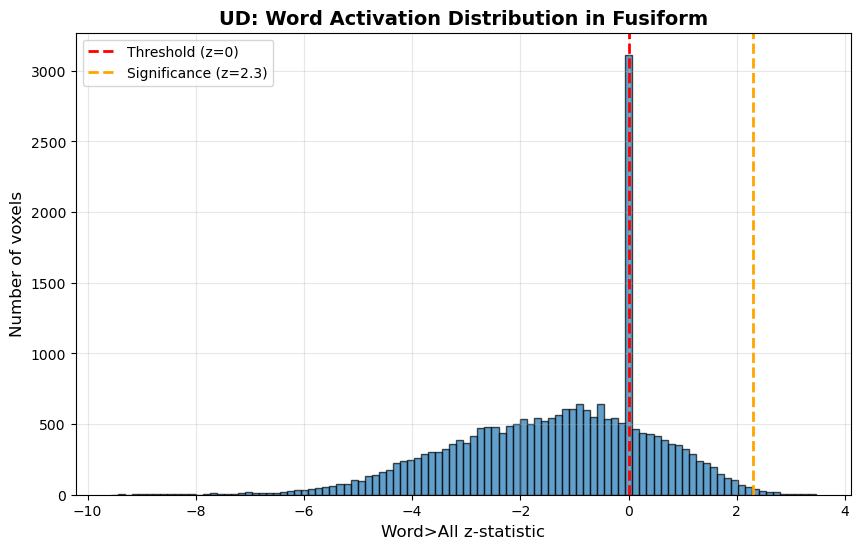

Word activation stats:
  Mean: -1.31
  Median: -1.03
  Min: -9.57, Max: 3.46
  Voxels > 0: 5033 (20.7%)
  Voxels > 2.3: 125 (0.5%)


In [22]:
# Visualize UD word activation (FIXED - remove vmin)

subject_id = 'sub-004'
hemi = 'l'

# Load files
anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
anat_boundary = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
word_activation = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                  'HighLevel.gfeat' / 'cope9.feat' / 'stats' / 'zstat1.nii.gz'
word_cluster = roi_results_dual[subject_id]['face_word']['cluster2_mask']

# Create word cluster image
word_cluster_img = nib.Nifti1Image(word_cluster.astype(np.float32), 
                                    nib.load(anat_boundary).affine)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Word activation with anatomical boundary
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[0, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word>All (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(anat_boundary, levels=[0.5], colors='cyan', linewidths=2)

# Row 2: Word cluster selection
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[1, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word Cluster (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(word_cluster_img, levels=[0.5], colors='lime', linewidths=3)

fig.suptitle('UD - Word Activation & Cluster Selection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'sub-004_word_cluster_review.png', dpi=150)
plt.show()

# Histogram
anat_mask = nib.load(anat_boundary).get_fdata() > 0
word_data = nib.load(word_activation).get_fdata()
word_values = word_data[anat_mask]

plt.figure(figsize=(10, 6))
plt.hist(word_values, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Threshold (z=0)')
plt.axvline(2.3, color='orange', linestyle='--', linewidth=2, label='Significance (z=2.3)')
plt.xlabel('Word>All z-statistic', fontsize=12)
plt.ylabel('Number of voxels', fontsize=12)
plt.title('UD: Word Activation Distribution in Fusiform', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Word activation stats:")
print(f"  Mean: {word_values.mean():.2f}")
print(f"  Median: {np.median(word_values):.2f}")
print(f"  Min: {word_values.min():.2f}, Max: {word_values.max():.2f}")
print(f"  Voxels > 0: {np.sum(word_values > 0)} ({100*np.sum(word_values > 0)/len(word_values):.1f}%)")
print(f"  Voxels > 2.3: {np.sum(word_values > 2.3)} ({100*np.sum(word_values > 2.3)/len(word_values):.1f}%)")

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_face_word_figure5_dual.png


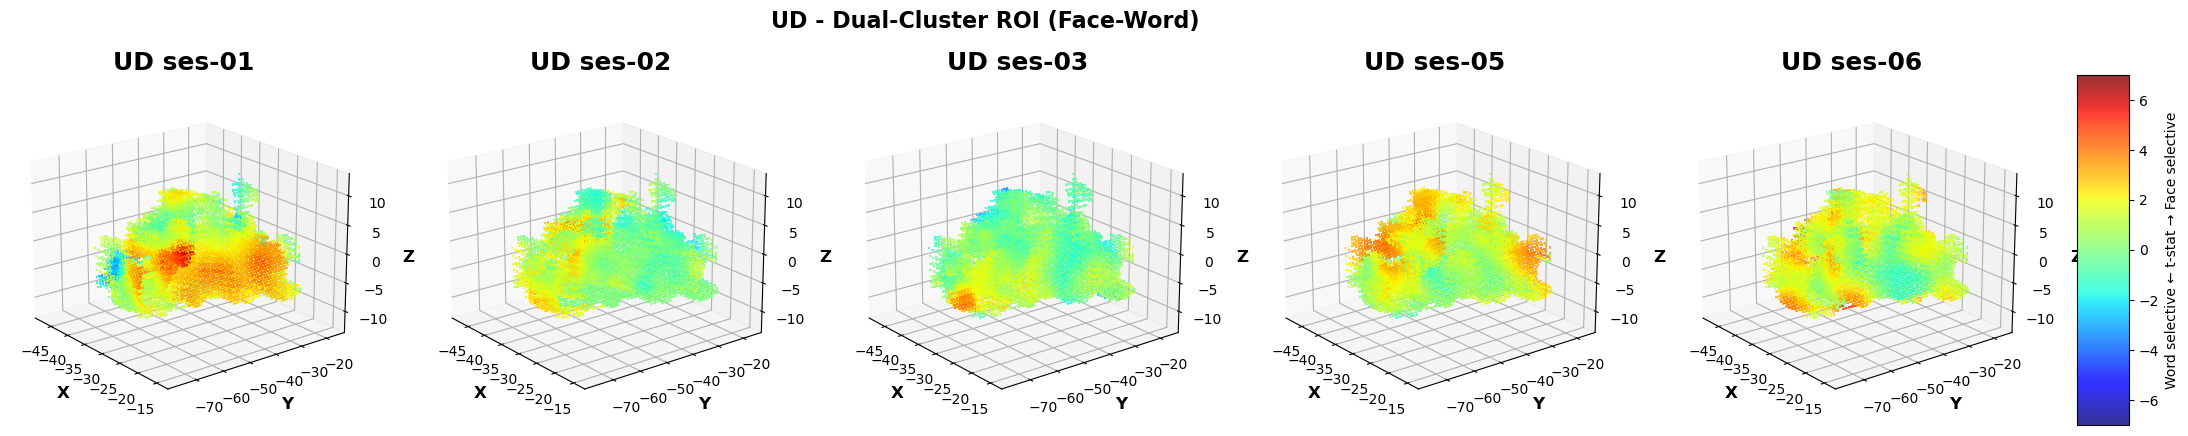

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_object_house_figure5_dual.png


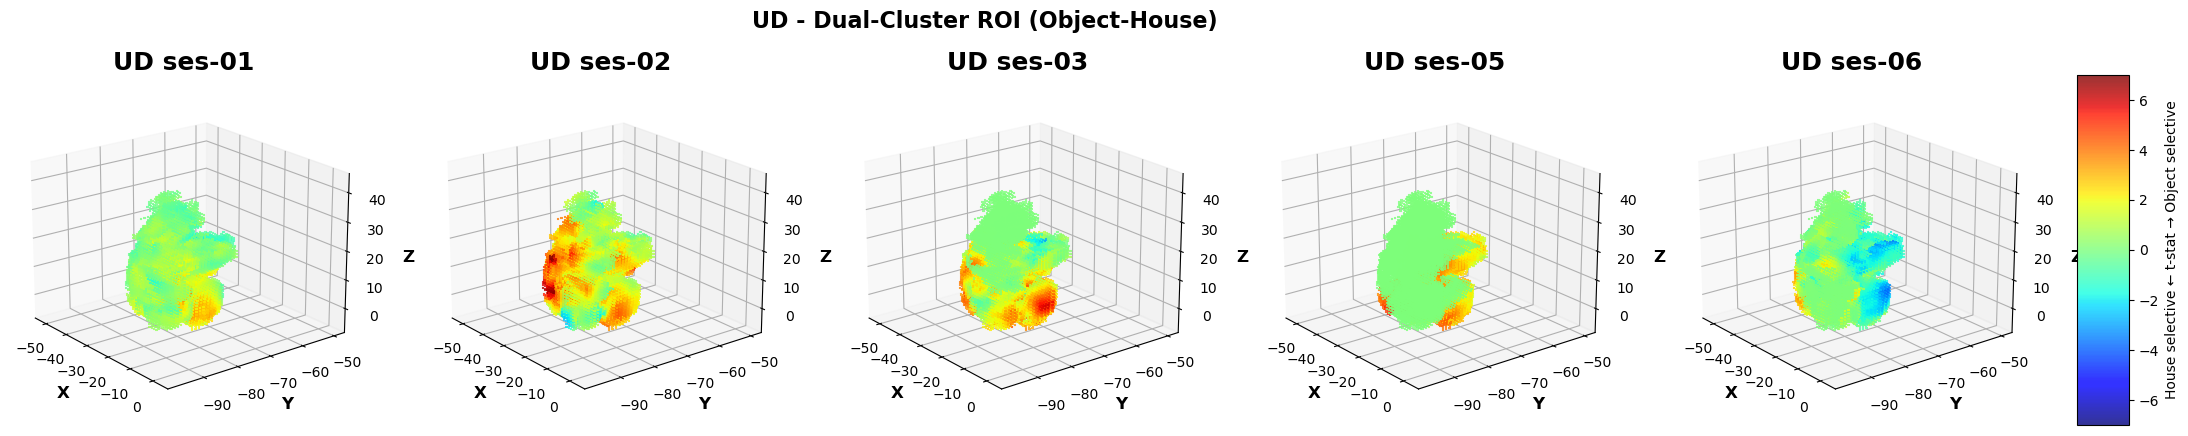

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_face_word_figure5_dual.png


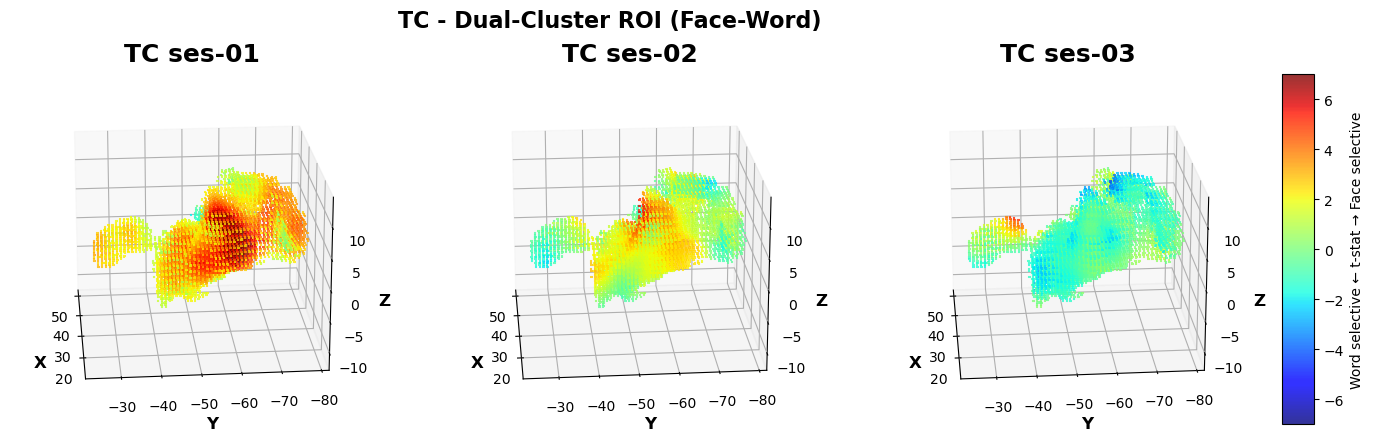

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_object_house_figure5_dual.png


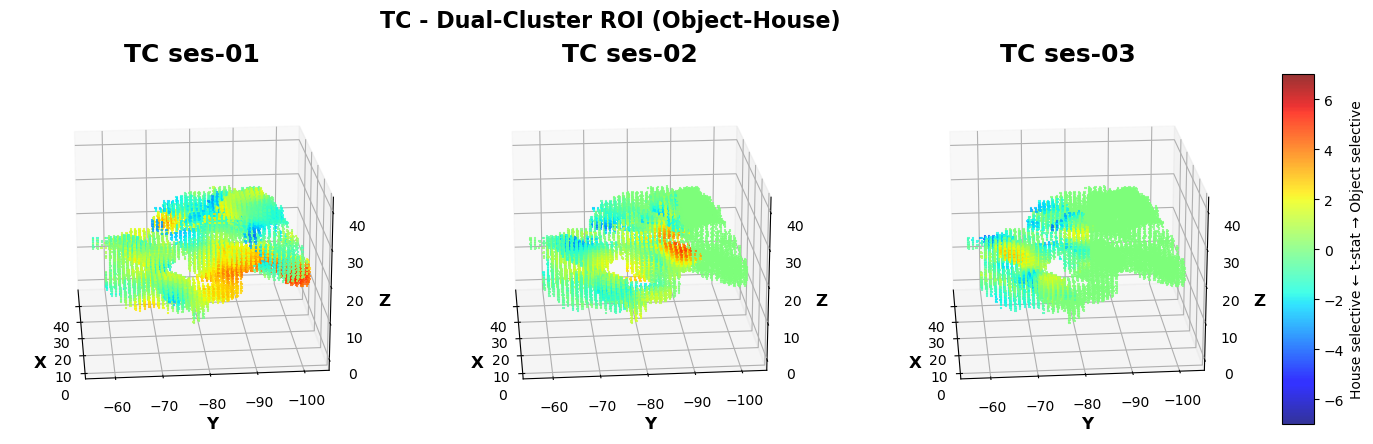

In [23]:
# Figure 5 style visualization for dual-cluster ROIs

def create_figure5_dual_cluster(subject_id, roi_type='face_word', save_path=None):
    """Figure 5 style 3D visualization for dual-cluster ROI"""
    
    info = SUBJECTS[subject_id]
    session_data = dual_extractions[subject_id][roi_type]['data']
    sessions = [s for s in info['sessions'] if s in session_data]
    n_sessions = len(sessions)
    
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for i, ses in enumerate(sessions):
        data = session_data[ses]
        coords = data[:, :3]
        t_stats = data[:, 3]
        
        ax = fig.add_subplot(1, n_sessions, i+1, projection='3d')
        
        # View angle
        view = (20, 175) if info['hemi'] == 'r' else (20, 322)
        
        scatter = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{info["code"]} ses-{ses}', fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t-stat → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t-stat → Object selective', fontsize=10)
    
    roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    fig.suptitle(f'{info["code"]} - Dual-Cluster ROI ({roi_label})', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Create visualizations for both contrasts
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_figure5_dual.png'
        create_figure5_dual_cluster(subject_id, roi_type, save_path)

In [20]:
# Extract cope 13 from dual-cluster ROIs

def extract_dual_cluster_longitudinal(subject_id, roi_type='face_word'):
    """Extract contrast from dual-cluster ROI across sessions"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    session_means = {}
    
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            t_stats = zstat_data[voxel_indices]
            
            # Store for Figure 5
            session_data[session] = np.column_stack([world_coords, t_stats])
            session_means[session] = t_stats.mean()
            
            print(f"{subject_id} {roi_type} ses-{session}: mean={t_stats.mean():.2f}, std={t_stats.std():.2f}")
    
    return session_data, session_means

# Extract for all subjects
print("Extracting dual-cluster ROI data...")
print("="*60)

dual_extractions = {}
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    dual_extractions[subject_id] = {}
    
    for roi_type in ['face_word', 'object_house']:
        print(f"\n  {roi_type}:")
        data, means = extract_dual_cluster_longitudinal(subject_id, roi_type)
        dual_extractions[subject_id][roi_type] = {'data': data, 'means': means}

Extracting dual-cluster ROI data...

UD:

  face_word:
sub-004 face_word ses-01: mean=1.62, std=1.49
sub-004 face_word ses-02: mean=0.47, std=1.10
sub-004 face_word ses-03: mean=0.29, std=1.05
sub-004 face_word ses-05: mean=1.27, std=1.16
sub-004 face_word ses-06: mean=1.45, std=1.09

  object_house:
sub-004 object_house ses-01: mean=0.73, std=1.10
sub-004 object_house ses-02: mean=1.89, std=1.46
sub-004 object_house ses-03: mean=1.37, std=1.48
sub-004 object_house ses-05: mean=1.20, std=1.52
sub-004 object_house ses-06: mean=-0.49, std=1.20

TC:

  face_word:
sub-021 face_word ses-01: mean=2.95, std=2.03
sub-021 face_word ses-02: mean=1.29, std=1.29
sub-021 face_word ses-03: mean=-0.61, std=0.98

  object_house:
sub-021 object_house ses-01: mean=0.39, std=1.58
sub-021 object_house ses-02: mean=-0.01, std=0.93
sub-021 object_house ses-03: mean=-0.13, std=0.70


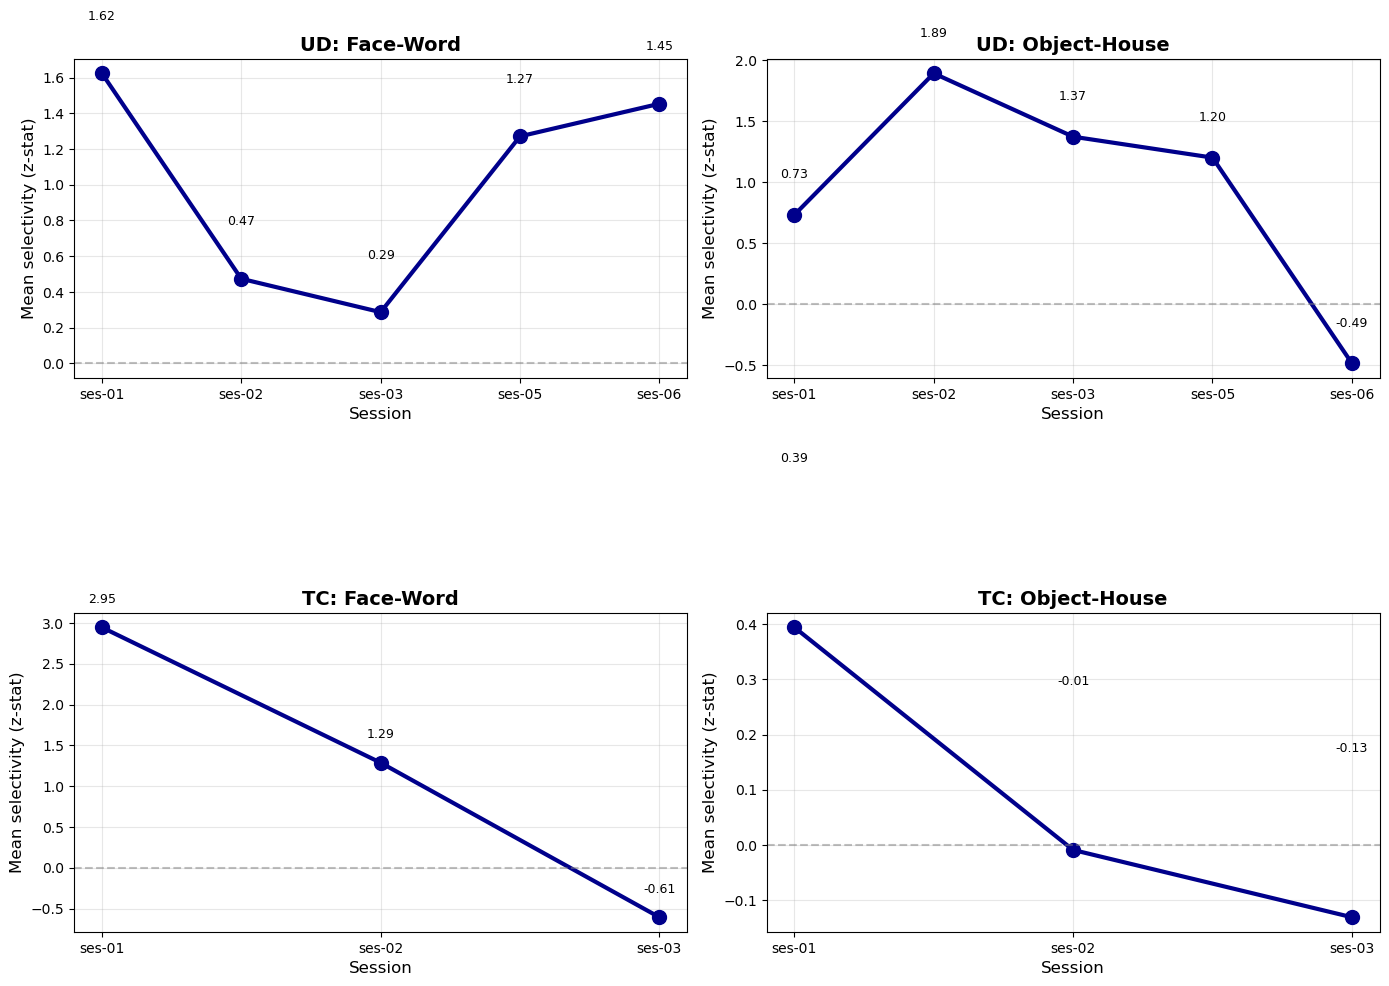


Extraction and visualization complete!


In [21]:
# Plot longitudinal progression

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for subj_idx, subject_id in enumerate(['sub-004', 'sub-021']):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for roi_idx, roi_type in enumerate(['face_word', 'object_house']):
        ax = axes[subj_idx, roi_idx]
        
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        # Get values in order
        sessions_available = [s for s in sessions if s in means_dict]
        means = [means_dict[s] for s in sessions_available]
        
        # Plot
        ax.plot(range(len(means)), means, 'o-', linewidth=3, markersize=10, color='darkblue')
        ax.set_xticks(range(len(sessions_available)))
        ax.set_xticklabels([f'ses-{s}' for s in sessions_available])
        ax.set_ylabel('Mean selectivity (z-stat)', fontsize=12)
        ax.set_xlabel('Session', fontsize=12)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # Title
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        ax.set_title(f'{code}: {roi_label}', fontsize=14, fontweight='bold')
        
        # Annotate values
        for i, (ses, val) in enumerate(zip(sessions_available, means)):
            ax.text(i, val + 0.3, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'dual_cluster_longitudinal.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("Extraction and visualization complete!")